In [1]:
import rasterio
from shapely.geometry import mapping
import rasterio.mask
from rasterio.mask import mask
import rasterio.features
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import generic_filter

/tmp/ipykernel_30064/3406766526.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9k2znzrj because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to

In [2]:
# dark mode for matplotlib
plt.style.use('dark_background')

In [3]:
brazil = gpd.read_file('data/brazil.geojson')

# Extract the geometry in GeoJSON format
geom = [mapping(brazil.geometry.unary_union)]


with rasterio.open('data/BRA_alt/BRA_alt.vrt') as src:
    # Mask the raster with Brazil geometry
    out_image, out_transform = mask(src, geom, crop=True)
    out_meta = src.meta
    
    
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
})

# Save the resulting raster  
out_file = "data/masked_raster.tif"

with rasterio.open(out_file, "w", **out_meta) as dest:
    dest.write(out_image)

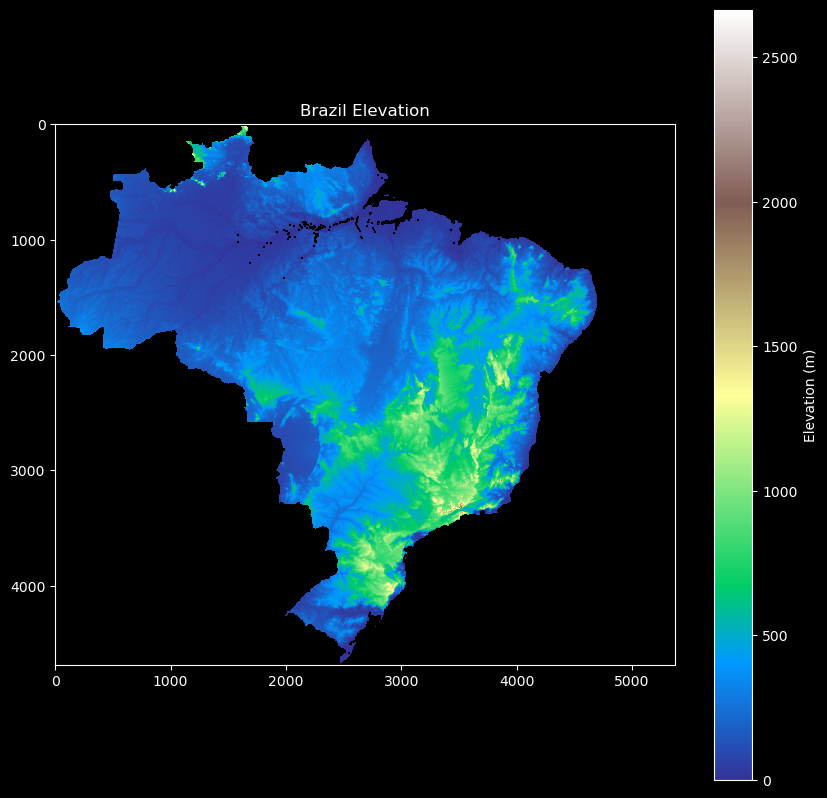

In [4]:
with rasterio.open('data/masked_raster.tif') as src:
    # Read the raster data
    raster = src.read(1)

# mask to exclude the ocean
raster_masked = np.where(raster < 0, np.nan, raster)

plt.figure(figsize=(10,10))
plt.imshow(raster_masked, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title('Brazil Elevation')
plt.show()

In [5]:
raster_masked

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [5]:
with rasterio.open('data/masked_raster.tif') as src:
    # Get the raster transform
    transform = src.transform
    crs = src.crs

# Print the resolution
print('Resolution: ', abs(transform[0]), 'x', abs(transform[4]), 'in degrees (grid resolution is approximately 1 km)')
print('CRS: ', crs)

# our data is using a geographic coordinate system based on the WGS84 ellipsoid, with coordinates given in degrees of latitude and longitude. 
# This is a very common system for global datasets, but since it's not an officially recognized system, it's labeled as "unknown".
# should consider to change the crs 


Resolution:  0.008333333 x 0.008333333 in degrees (grid resolution is approximately 1 km)
CRS:  GEOGCS["unknown",DATUM["Unknown based on WGS84 ellipsoid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


In [2]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:32723' # UTM Zone 23S

with rasterio.open('data/masked_raster.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('data/masked_raster_UTM.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)


In [8]:
# change crs to UTM

with rasterio.open('data/masked_raster_UTM.tif') as src:
    # Read the raster data
    raster_UTM = src.read(1)

# mask to exclude the ocean (assuming that the elevation of ocean areas is still negative)
raster_UTM_masked = np.where(raster_UTM < 0, np.nan, raster_UTM)



In [9]:
# Open the reprojected raster file
with rasterio.open('data/masked_raster_UTM.tif') as src:
    print(src.crs)      # Check the CRS
    print(src.transform)  # Check the transform


EPSG:32723
| 927.24, 0.00,-2873288.24|
| 0.00,-927.24, 10666646.73|
| 0.00, 0.00, 1.00|


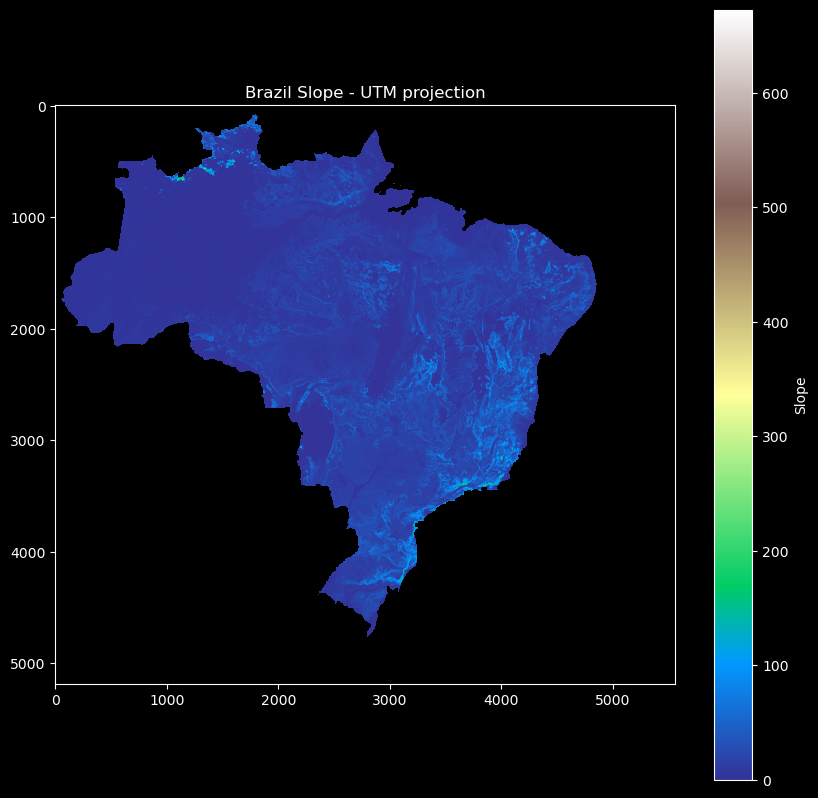

In [3]:

# reprojected raster file
with rasterio.open('data/masked_raster_UTM.tif') as src:
    # Read the raster data
    raster_UTM = src.read(1)

# Replace nan values with a placeholder value
raster_UTM_no_nan = np.where(np.isnan(raster_UTM), -9999, raster_UTM)


def calculate_slope(elevations):
    # If there's a placeholder value in the neighborhood, return placeholder
    if -9999 in elevations:
        return -9999
    # Otherwise, calculate the slope
    dz_dx = (elevations[2] + 2*elevations[5] + elevations[8] - elevations[0] - 2*elevations[3] - elevations[6]) / 8
    dz_dy = (elevations[0] + 2*elevations[1] + elevations[2] - elevations[6] - 2*elevations[7] - elevations[8]) / 8
    slope = np.sqrt(dz_dx**2 + dz_dy**2)
    return slope

# Apply the function to the raster data
slope = generic_filter(raster_UTM_no_nan, calculate_slope, size=3)

# Replace placeholder values with nan for visualization
slope = np.where(slope == -9999, np.nan, slope)


plt.figure(figsize=(10,10))
plt.imshow(slope, cmap='terrain')
plt.colorbar(label='Slope')
plt.title('Brazil Slope - UTM projection')
plt.show()

# slope valuesrepresent the amount of vertical change (in meters) for every unit of horizontal change


In [7]:
max_slope = np.nanmax(slope)
print(max_slope)

# Calculate the 95th percentile of the slope values, ignoring NaN values
max_slope_95 = np.nanpercentile(slope, 95)

print(max_slope_95)


673.0
50.0


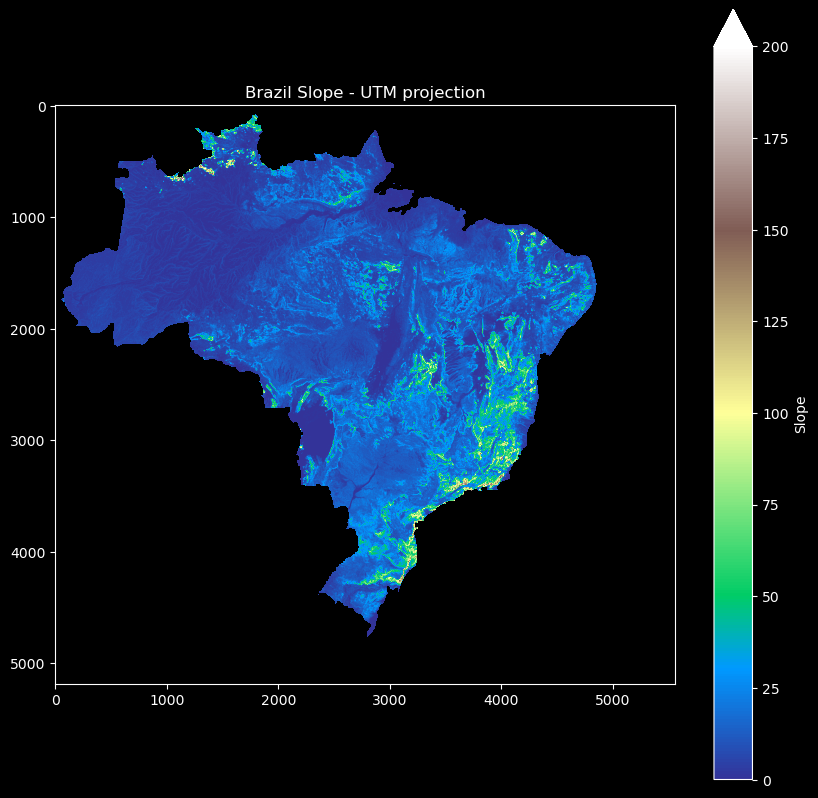

In [5]:
max_slope_color = 200

plt.figure(figsize=(10,10))
imgplot = plt.imshow(slope, cmap='terrain', vmin=0, vmax=max_slope_color)
plt.colorbar(label='Slope', extend='max')  # 'extend' option indicates values exceed max color limit
plt.title('Brazil Slope - UTM projection')
plt.show()